# Image Classification Task
1. Train 2 different models and get results.<br>
      1.1. Download the image classification data. <br>
      1.2. Train a classification model (using PyTorch or Tensorflow) to classify the tissue images into organ systems they come from. (Do not use a pre-trained model. You should create a model and a dataloader from scratch.)<br>
      1.3. Train a classification model (using Pytorch or Tensorflow) to classify the tissue images into organ systems they come from. Use a pre-trained model such as VGG, Inception, Efficientnet etc. You may use in-built functions to create your model and dataloader.<br>
      1.4. Calculate the training and test accuracy of your model. <br>
2. Visualize <br>
      2.1. Overlap between training and test datasets in 2D, e.g., using t-SNE, UMAP, MDS etc. <br>
      2.2. Prediction results <br>
3. Explain why some images might have been classified incorrectly.
4. Read a paper and write a 1-page (500 words) summary. (Paper Drive link: https://drive.google.com/file/d/1p1g76HBOIa8qpGQzattBmOgBno933lPt/view?usp=sharing Paper Nature link: https://www.nature.com/articles/s41592-019-0403-1 )

# 1. Train 2 different models and get results

## 1.1 Download the image classification data.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
%cd '/Users/kartikbharadwaj/Downloads/cns_project/Data'

/Users/kartikbharadwaj/Downloads/cns_project/Data


In [3]:
! pwd

/Users/kartikbharadwaj/Downloads/cns_project/Data


In [4]:
#importing libraries

import torch
from torch import autograd
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imutils
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import copy
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 1.1.1 Loading the data using Custom DataLoader Class of pytorch

In [39]:
class DataLoaderCustom(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        
        self.labels = []
        self.img_path = []
        main_folders = os.listdir(root_dir)
        main_folders = [x for x in main_folders if x != '.DS_Store']
        for m_f in main_folders:
            folders = os.listdir(root_dir + '/' +  m_f + '/' + 'train/' if root_dir.split('/')[-1] == 'train' else root_dir + '/' +  m_f + '/' + 'test/')
            folders = [x for x in folders if '.DS_Store' not in x]
            for f in folders:
                path = os.path.join(root_dir, m_f + '/', 'train/' if root_dir.split('/')[-1] == 'train' else 'test/' , f + '/')
                img_path = os.listdir(path)
                for img_p in img_path:
                    self.labels.append(f)
                    self.img_path.append(path + img_p)

        self.order = list(set(self.labels))

    def __len__(self):
        return len(self.labels)

    def get_ohe_label(self, label):
      ret = np.zeros(len(self.order))
      ret[self.order.index(label)] = 1
      return torch.tensor(ret)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = cv2.imread(self.img_path[idx])
        img = cv2.resize(img,(224,224)) 
        true_label = self.labels[idx]
        label = self.get_ohe_label(true_label)
        sample = {'image': img, 'label': label, 'true_label': true_label}

        if self.transform:
            sample['image'] = self.transform(Image.fromarray(sample['image']))
            sample['image'] = transforms.functional.adjust_sharpness(sample['image'],sharpness_factor=5)

        return sample

In [40]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(90), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(90),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

trainset = DataLoaderCustom(root_dir='/Users/kartikbharadwaj/Downloads/cns_project/Data/train', transform=transform_train)
testset = DataLoaderCustom(root_dir='/Users/kartikbharadwaj/Downloads/cns_project/Data/test', transform=transform_test)

batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [41]:
dataiter = iter(trainloader)
data = dataiter.next()

print('Size of Batched data = ', data['image'].shape)

print('Size of Batched data Images  = ', data['image'][1].shape)
print('True Label = ', data['true_label'][1])
print('One Hot encoded Label = ', data['label'][1])


Size of Batched data =  torch.Size([16, 3, 224, 224])
Size of Batched data Images  =  torch.Size([3, 224, 224])
True Label =  colon
One Hot encoded Label =  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=torch.float64)


Total number of images in train dataset =  1094
Total number of images in test dataset =  611


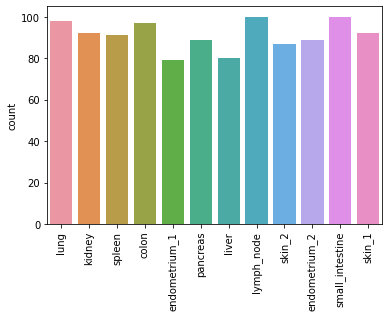

In [42]:
print('Total number of images in train dataset = ', len(trainset))
print('Total number of images in test dataset = ', len(testset))

# The dataset is balanced
sns.countplot(trainset.labels)
plt.xticks(rotation=90)
plt.show()

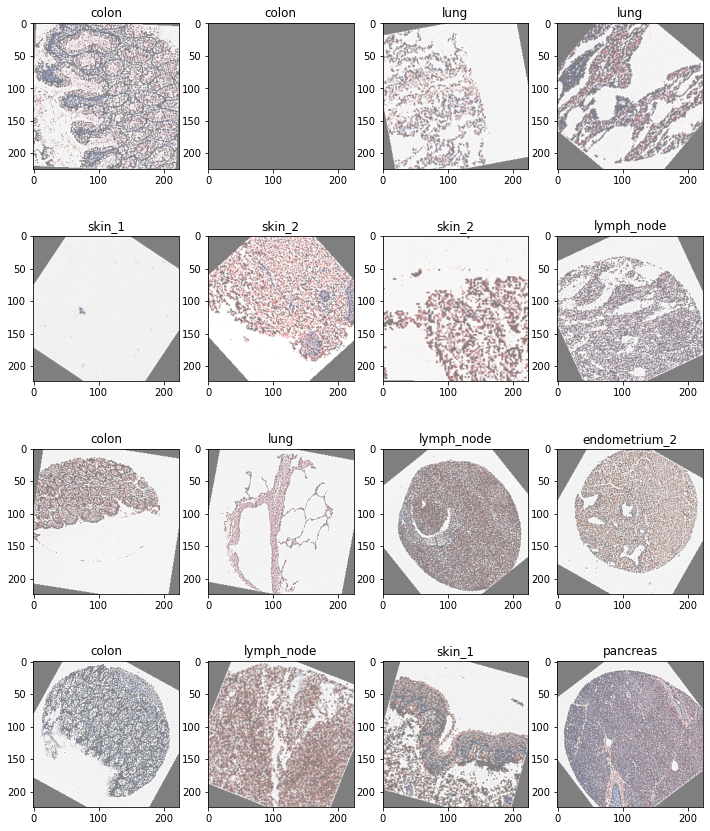

In [43]:
fig, axs = plt.subplots(4, 4, figsize=(12,15))

temp = 0
for i in range(4):
  for j in range(4):
    axs[i, j].imshow(np.transpose(data['image'][temp].numpy() / 2 + 0.5, (1, 2, 0)))
    axs[i, j].set_title(data['true_label'][temp])
    temp+=1

plt.show()

Loading the data using the DataLoader class will take a lot of time because dataloader does not save the image into memory once loaded. therefore it will again and again make a call to the google drive to load the image which will increces the time due to I/O.

### 1.1.2 Loading the data using custom loader that store the data in momory at once

In [ ]:
#  This was used when working on colab
# 
# 
#  # custom dataset loader(NOTE: this changes with different datasets)
# def dataloader(dir, tot = None):  
#     images = []
#     labels = []
#     path_list = []
#     folders = os.listdir(dir)
#     # loading the folders inside train
#     for f in folders:
#       path = os.path.join(dir, f + '/')
#       img_path = os.listdir(path)
#       # loading the images inside the folders
#       for img_p in img_path:
#         path_list.append((path + img_p, f))
    
#     random.shuffle(path_list)  
#     for x in tqdm(path_list):
#       img = cv2.imread(x[0])
#       img = cv2.resize(img,(224,224))                 #resize all the image to 224,224,3 which vgg16 accepts
#       images.append(img)
#       labels.append(x[1])
      
#       # data Augmentation
#       if random.randint(1, 50) % 10 == 0:
#         images.append(cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE))
#         labels.append(f)
#       elif random.randint(1, 50) % 8 == 0:
#         images.append(cv2.rotate(img, cv2.cv2.ROTATE_180))
#         labels.append(f)
#       elif random.randint(1, 50) % 6 == 0:
#         images.append(cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))
#         labels.append(f)
#       elif random.randint(1, 50) % 4 == 0:
#         images.append(cv2.flip(img, 0))
#         labels.append(f)
#       elif random.randint(1, 50) % 2 == 0:
#         images.append(cv2.flip(img, -1))
#         labels.append(f)
#       elif random.randint(1, 50) % 12 == 0:
#         images.append(cv2.flip(img, 1))
#         labels.append(f)

#       if tot:
#         if len(labels) > tot:
#           return torch.tensor(images), labels
#     return torch.tensor(images), labels 

In [ ]:
# def get_ohe_label(labels, idx = None):
#   if idx is None:
#     idx = list(set(labels))

#   label = [idx.index(x) for x in labels]

#   return torch.nn.functional.one_hot(torch.tensor(label)), idx

In [13]:
# images, label = dataloader('/content/drive/MyDrive/ml_hiring_data/data/train/')
# images_test, label_test = dataloader('/content/drive/MyDrive/ml_hiring_data/data/test/')

100%|██████████| 600/600 [27:05<00:00,  2.71s/it]


### Visializing the data

Total number of images in train dataset =  2114
Total number of images in test dataset =  1063


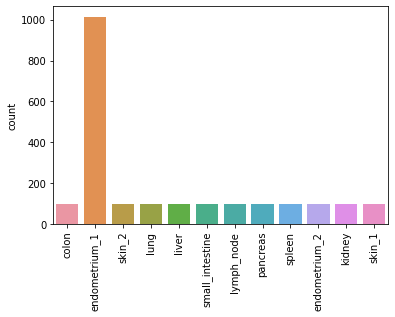

In [14]:
# print('Total number of images in train dataset = ', len(images))
# print('Total number of images in test dataset = ', len(images_test))

# # The dataset is balanced
# sns.countplot(label)
# plt.xticks(rotation=90)
# plt.show()

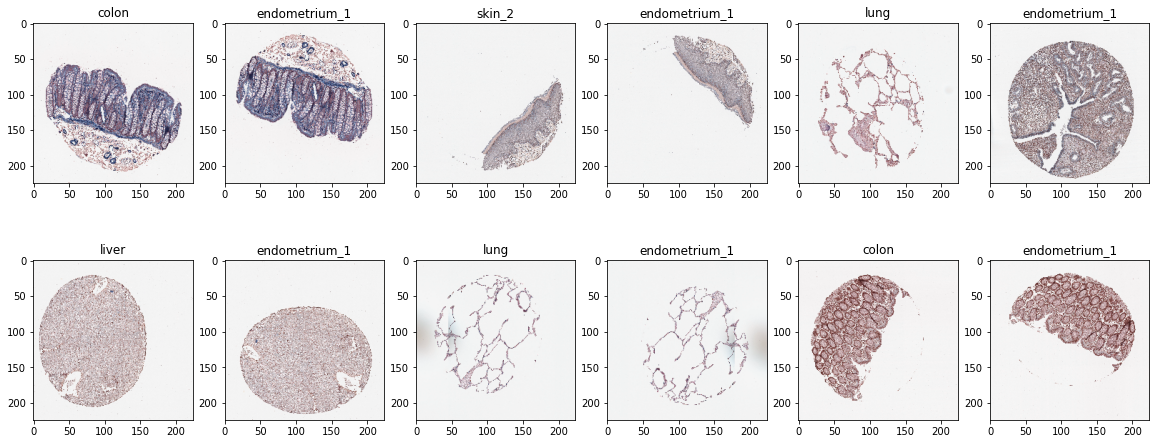

In [15]:
# index = [i for i in range(1, len(label)) if label[i-1] != label[i]]
# index = [0] + index

# fig, axs = plt.subplots(2, 6, figsize=(20,8))

# temp = 0
# for i in range(2):
#   for j in range(6):
#     axs[i, j].imshow(images[index[temp]])
#     axs[i, j].set_title(label[index[temp]])
#     temp+=1

# plt.show()


In [16]:
# labels, order = get_ohe_label(label)
# images, labels = images.to(device), labels.to(device)

# labels_test, _ = get_ohe_label(label_test, order)
# images_test, labels_test = images_test.to(device), labels_test.to(device)

## 1.2 Train a classification model (using PyTorch or Tensorflow) to classify the tissue images into organ systems they come from. (Do not use a pre-trained model. You should create a model and a dataloader from scratch.)

In [44]:
class Classifier(nn.Module):
    def __init__(self): 
        super(Classifier, self).__init__()
        
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),           # (N, 3, 224, 224) -> (N,  6, 220, 220)
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, stride=2),    # (N, 6, 220, 220) -> (N,  6, 110, 110)
            nn.Conv2d(6, 16, 5),          # (N, 6, 110, 110) -> (N, 16, 106, 106)  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2),    # (N,16, 106, 106) -> (N, 16, 53, 53)
            nn.Conv2d(16, 16, 5),         # (N, 16, 53, 53) -> (N, 16, 48, 48)  
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2),    # (N,16, 48, 48) -> (N, 16, 24, 24)
            nn.Conv2d(16, 16, 5),         # (N, 16, 24, 24) -> (N, 16, 20, 20)  
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2)     # (N,16, 20, 20) -> (N, 16, 10, 10)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(1600,800),          # (N, 1600) -> (N, 800)
            nn.Dropout(0.05),
            nn.Linear(800,400),          # (N, 800) -> (N, 400)
            nn.Dropout(0.05),
            nn.Linear(400, 120),          # (N, 400) -> (N, 120)
            nn.Dropout(0.05),
            nn.Linear(120,50),            # (N, 120) -> (N, 50)
            nn.Dropout(0.05),
            nn.Linear(50,12)              # (N, 50)  -> (N, 12)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_model(x)
        return x

In [68]:
def evaluation(images, labels, net):
    total, correct = 0, 0
    for data, l in zip(images, labels):
        data = data/255
        outputs = net(torch.unsqueeze(data.permute(2, 1, 0), 0).to(torch.float))
        _, pred = torch.max(outputs.data, 1)
        _, l = torch.max(l, 0)
        total += 1
        correct += (pred == l).sum().item()
    return 100 * correct / total

def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data['image'], data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        _, l = torch.max(labels, 1)
        total += labels.size(0)
        correct += (pred == l).sum().item()
    return 100 * correct / total

In [69]:
old = False

In [70]:
net = Classifier()

if old:
  # load trained from drive--/content/drive/My Drive/
  net.load_state_dict(torch.load('/Users/kartikbharadwaj/Downloads/cns_project/model_custom.pth', map_location= 'cpu')) 

net.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.005)

Epoch: 0/5, Test acc: 9.33, Train acc: 10.05


Epoch: 1/5, Test acc: 13.26, Train acc: 18.46


Epoch: 2/5, Test acc: 13.42, Train acc: 17.82


Epoch: 3/5, Test acc: 10.97, Train acc: 14.44


Epoch: 4/5, Test acc: 10.64, Train acc: 18.83


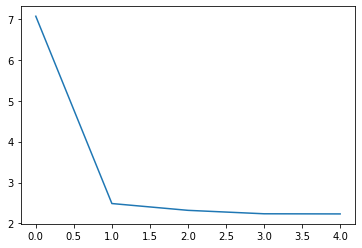

In [71]:
#%%time

loss_epoch_arr = []
max_epochs = 5
batch = 8
acc = 0

for epoch in tqdm(range(max_epochs)):
    loss_arr = []
    #arr = list(range(len(labels)))
    #random.shuffle(arr)
    #for k in range(0, len(labels), batch):
        #data, l = images[arr[k:k+batch]], labels[arr[k:k+batch]]
        #data = data/255.0
        #data, l  = torch.tensor(data), torch.tensor(l)
    for i, data in enumerate(trainloader):    
        
        inputs, labels = data['image'], data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()
        
        #outputs = net(data.permute(0, 3, 1, 2).to(torch.float))
        outputs = net(inputs)
        _, l = torch.max(labels,1)
        
        loss = loss_fn(outputs, l.to(torch.long))
        
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
        
    loss_epoch_arr.append(sum(loss_arr)/len(loss_arr))

    test_acc = evaluation(testloader,net)
    train_acc = evaluation(trainloader,net)

    if acc < test_acc:
          acc = test_acc
          best_model = copy.deepcopy(net)
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'%(epoch,max_epochs,test_acc,train_acc)) 
    # evaluation(images_test,labels_test,net),evaluation(images,labels,net)
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [72]:
if not old:
  torch.save(best_model.state_dict(), '/Users/kartikbharadwaj/Downloads/cns_project/model_custom.pth')

In [74]:
net = Classifier()
net.load_state_dict(torch.load('/Users/kartikbharadwaj/Downloads/cns_project/model_custom.pth', map_location= 'cpu')) 
net.to(device)

print('Training Accuracy on Custom model = ', evaluation(trainloader,net))
print('Test Accuracy on Custom model = ', evaluation(testloader,net))

Training Accuracy on Custom model =  18.46435100548446
Test Accuracy on Custom model =  13.911620294599018


In [82]:
pred_test_c = []
l_test_c = []
for i, data in enumerate(testloader):
    inputs, labels = data['image'], data['label']
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    _, l = torch.max(labels, 1)
    for i in range(len(pred)):
        pred_test_c.append(trainset.order[pred[i].item()])
        l_test_c.append(trainset.order[l[i].item()])

## 1.3. Train a classification model (using Pytorch or Tensorflow) to classify the tissue images into organ systems they come from. Use a pre-trained model such as VGG, Inception, Efficientnet etc. You may use in-built functions to create your model and dataloader.

In [83]:
class Classifier_vgg(nn.Module):
    def __init__(self): 
        super(Classifier_vgg, self).__init__()

        self.cnn_model = models.vgg16_bn(pretrained=True)
        for param in self.cnn_model.parameters():
          param.requires_grad = False 
        self.final_in_features = self.cnn_model.classifier[6].in_features
        self.cnn_model.classifier[6] = nn.Linear(self.final_in_features, 12)

        
    def forward(self, x):
        x = self.cnn_model(x)
        return x

In [84]:
old = False

In [85]:
net = Classifier_vgg()
if old:
  # load trained from drive--/content/drive/My Drive/
  net.load_state_dict(torch.load('/Users/kartikbharadwaj/Downloads/cns_project/model_vgg.pth', map_location= 'cpu')) 

net.to(device)
loss_fn = nn.CrossEntropyLoss()
# opt = optim.Adam(net.parameters())
opt = optim.SGD(net.parameters(), lr=0.05)

In [86]:
#%%time

loss_epoch_arr = []
max_epochs = 5
batch = 8
min_loss = 9999

for epoch in range(max_epochs):
    loss_arr = []
    #arr = list(range(len(labels)))
    #random.shuffle(arr)
    #for k in range(0, len(arr), batch):
        #data, l = images[arr[k:k+batch]], labels[arr[k:k+batch]]
        #data = data/255.0
        #data, l  = torch.tensor(data), torch.tensor(l)
    for i, data in enumerate(trainloader):    
        
        inputs, labels = data['image'], data['label']
        inputs, labels = inputs.to(device), labels.to(device)
            
        opt.zero_grad()
        
        #outputs = net(data.permute(0, 3, 1, 2).to(torch.float))
        outputs = net(inputs)
        _, l = torch.max(labels,1)

        #_, l = torch.max(l,1)
        
        loss = loss_fn(outputs, l)
        
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
        
    loss_epoch_arr.append(sum(loss_arr)/len(loss_arr))

    test_acc = evaluation(testloader,net)
    train_acc = evaluation(trainloader,net)

    if acc < test_acc:
          acc = test_acc
          best_model = copy.deepcopy(net)
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'%(epoch,max_epochs,test_acc,train_acc)) 
    # evaluation(images_test,labels_test,net),evaluation(images,labels,net)
    
    
plt.plot(loss_epoch_arr)
plt.show()

Epoch: 0/5, Test acc: 18.99, Train acc: 43.69
Epoch: 1/5, Test acc: 22.91, Train acc: 49.45
Epoch: 2/5, Test acc: 16.20, Train acc: 38.21
Epoch: 3/5, Test acc: 15.71, Train acc: 32.45


KeyboardInterrupt: 

In [87]:
if not old:
  torch.save(best_model.state_dict(), '/Users/kartikbharadwaj/Downloads/cns_project/model_vgg.pth')

In [90]:
net = best_model

print('Training Accuracy on VGG model = ', evaluation(trainloader,net))
print('Test Accuracy on VGG model = ', evaluation(testloader,net))

Training Accuracy on VGG model =  51.005484460694696
Test Accuracy on VGG model =  22.913256955810148


The VGG model is overfitting at this configuration

In [91]:
pred_test_v = []
l_test_v = []
for i, data in enumerate(testloader):
    inputs, labels = data['image'], data['label']
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    _, l = torch.max(labels, 1)
    for i in range(len(pred)):
        pred_test_v.append(trainset.order[pred[i].item()])
        l_test_v.append(trainset.order[l[i].item()])

# 2. Visualize

## 2.1 Overlap between training and test datasets in 2D, e.g., using t-SNE, UMAP, MDS etc.

In [93]:
from sklearn.manifold import TSNE

tsne = []
lab = []
for i, data in enumerate(trainloader):
    img, l = data['image'], data['true_label']
    t = TSNE(n_components=2).fit_transform(img.reshape(img.shape[0], -1))
    tsne.extend(t)
    lab.extend(l)

tsne = np.array(tsne)
lab = np.array(lab)

<AxesSubplot:>

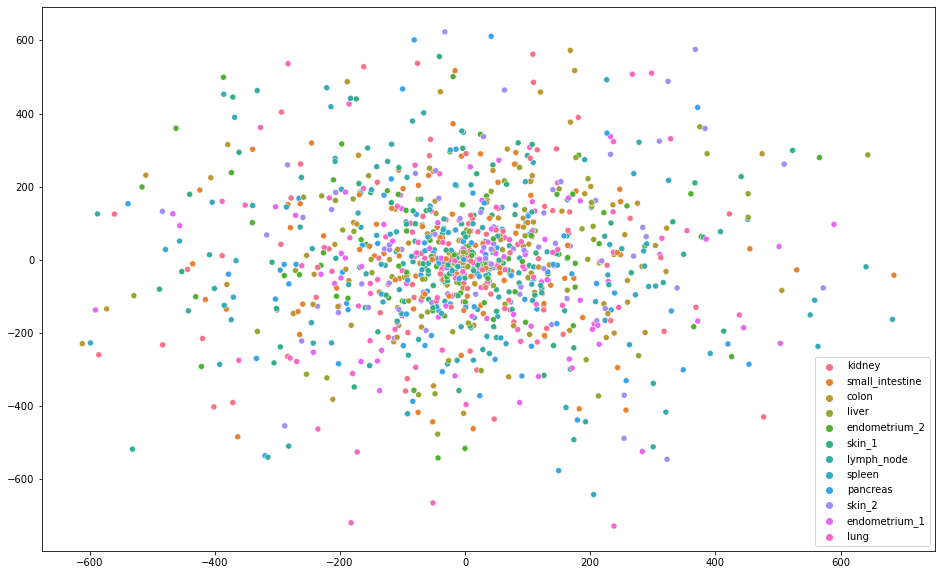

In [94]:
# tsne = TSNE(n_components=2).fit_transform(images.reshape(images.shape[0], -1))
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne[:,0], y=tsne[:,1],
    hue=lab
)

## 2.2. Prediction results

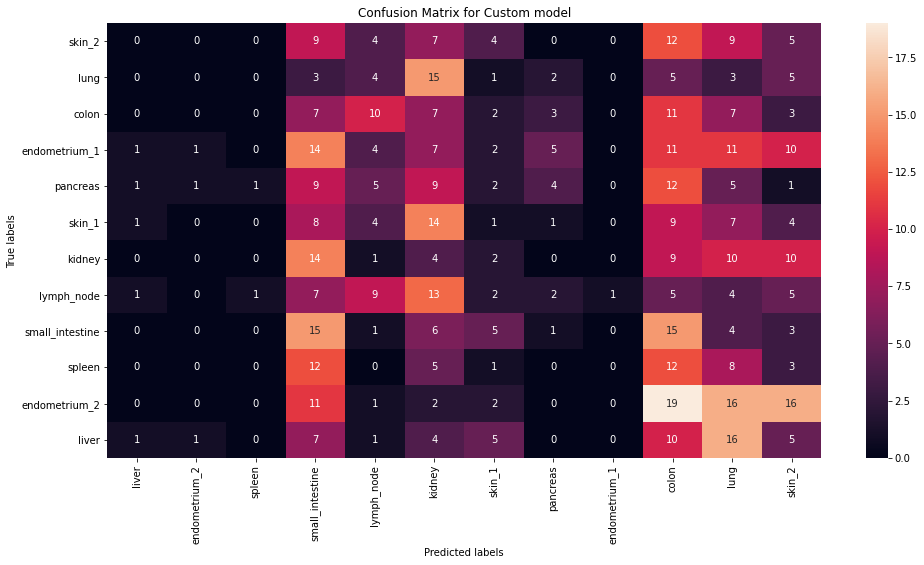

In [95]:
plt.figure(figsize=(16,8))
cm = confusion_matrix(y_true = l_test_c, y_pred = pred_test_c, labels = trainset.order)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Custom model')
ax.xaxis.set_ticklabels(trainset.order)
ax.yaxis.set_ticklabels(trainset.order[::-1])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

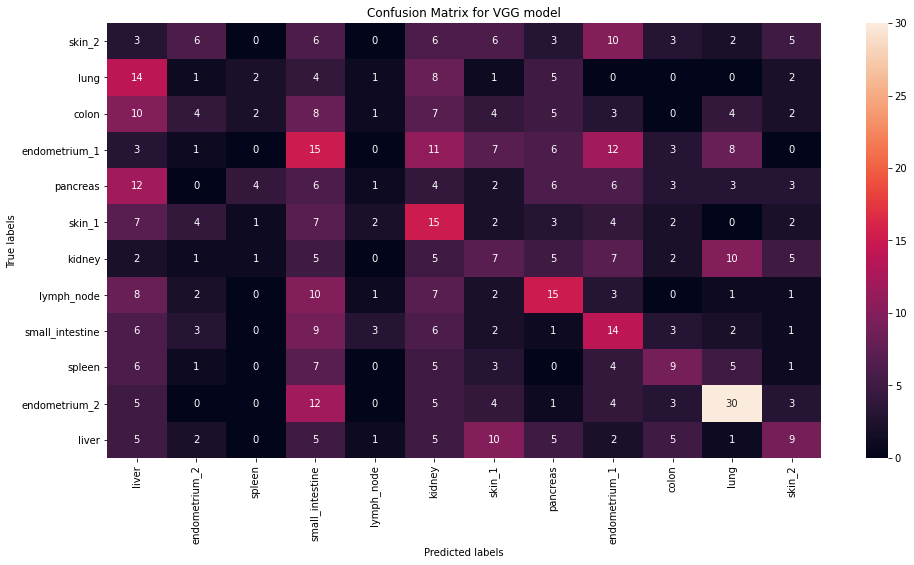

In [96]:
plt.figure(figsize=(16,8))
cm = confusion_matrix(y_true = l_test_v, y_pred = pred_test_v, labels = trainset.order)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for VGG model')
ax.xaxis.set_ticklabels(trainset.order)
ax.yaxis.set_ticklabels(trainset.order[::-1])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# 3. Explain why some images might have been classified incorrectly.

1. using TSNE we see a lot of overlap between the images which is leading to model confussion
2. Small intestine, Kidney and Lymp node have a lot of common features in their images. This is leading to bad classification rate.
3. Colon, lung and skin_2 are also being confused by the model.